In [44]:
import torch
from data_loader import CustomDataLoader
from torch.utils.data import DataLoader
import ukis_metrics.seg_metrics as segm

import warnings
warnings.filterwarnings('ignore')

In [45]:
model_ckpt = './networks/2024_04_16-16_37_36_encoder_efficientnet-b0_weights_imagenet_epochs_100_batchsize_16_lr_0.001/model_0.38835_val_avg.pt'

In [46]:
import pickle

# Take the same path and find the associated parameter file
path = '/'.join(model_ckpt.split('/')[:-1]) + '/params.pkl'
with open(path, 'rb') as f:
    loaded_dict = pickle.load(f)
print(loaded_dict) # Show the parameter file's contents

import ast # Test how string-to-dict works
ast.literal_eval(str(loaded_dict))

channels = loaded_dict['channels']

{'epochs': 100, 'batch_size': 16, 'lr': 0.001, 'encoder': 'efficientnet-b0', 'weights': 'imagenet', 'model_ckpt_path': './networks', 'data_path': '../data_prepped', 'channels': 'r.g.b'}


In [47]:
%%time
from model import SegmentationModel

model = SegmentationModel('efficientnet-b0', 'imagenet', channels = channels)
model.load_state_dict(torch.load(model_ckpt, map_location=torch.device('cuda')))
model.eval()

CPU times: user 527 ms, sys: 62.4 ms, total: 589 ms
Wall time: 679 ms


SegmentationModel(
  (cnn): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): I

In [48]:
data_path = '../denmark_data'
image_path = data_path + '/{}/img/*'
mask_path = data_path + '/{}/msk/*'
 
# Use custom data loaders for S1S2 dataset
test_dataset = CustomDataLoader(image_path.format('test'), mask_path.format('test'), channels = channels)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False, num_workers = 8)

In [49]:
def metric_for_ratio(masks, pred_masks, ratio):
    pred_masks = (pred_masks > ratio).cpu().bool()
    masks = masks.bool()

    tpfptnfn = segm.tpfptnfn(masks == 1, pred_masks, None)
    metrics = segm.segmentation_metrics(tpfptnfn)
    # print(ratio, metrics)
    return metrics

In [50]:
torch.multiprocessing.set_sharing_strategy('file_system')
from tqdm import tqdm 
import numpy as np 

device = 'cuda'
model = model.to(device)

tpfptnfn = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0, 'n_valid_pixel': 0}
ratio = 0.8

i = 0
for ratio in [0.01, 0.05, 0.1, 0.2, 0.4]:
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images = images.to(device, dtype = torch.float32)
    
            logits = model(images, None)
            preds = torch.sigmoid(logits)
            preds = (preds > ratio).bool()
    
            masks = masks.bool().to(device)
    
            # Compute the classification performance
            tpfptnfn['tp'] += torch.sum((preds == 1) & (masks == 1)).cpu().numpy()
            tpfptnfn['fn'] += torch.sum((preds == 0) & (masks == 1)).cpu().numpy()
            tpfptnfn['tn'] += torch.sum((preds == 0) & (masks == 0)).cpu().numpy()
            tpfptnfn['fp'] += torch.sum((preds == 1) & (masks == 0)).cpu().numpy()
            tpfptnfn['n_valid_pixel'] += np.prod(masks.shape) # Get the number of pixels
    
        metrics = segm.segmentation_metrics(tpfptnfn)
        print(ratio, metrics)

100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [06:34<00:00, 17.50it/s]


0.01 {'iou': 0.0, 'recall': 0.0, 'precision': 0.0017, 'acc': 0.978, 'F1': 0.0, 'kappa': -0.0}


100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [06:32<00:00, 17.55it/s]


0.05 {'iou': 0.0, 'recall': 0.0, 'precision': 0.0033, 'acc': 0.978, 'F1': 0.0, 'kappa': -0.0}


100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [06:30<00:00, 17.64it/s]


0.1 {'iou': 0.0, 'recall': 0.0, 'precision': 0.0042, 'acc': 0.978, 'F1': 0.0, 'kappa': -0.0}


100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [06:35<00:00, 17.44it/s]


0.2 {'iou': 0.0, 'recall': 0.0, 'precision': 0.004, 'acc': 0.978, 'F1': 0.0, 'kappa': -0.0}


100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [06:37<00:00, 17.37it/s]

0.4 {'iou': 0.0, 'recall': 0.0, 'precision': 0.004, 'acc': 0.978, 'F1': 0.0, 'kappa': -0.0}


In [51]:
images.shape

torch.Size([2, 3, 512, 512])

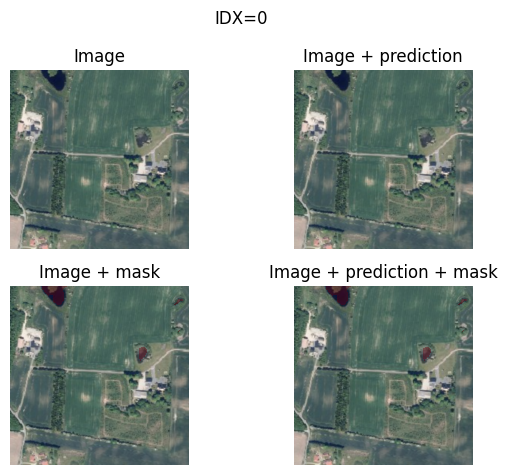

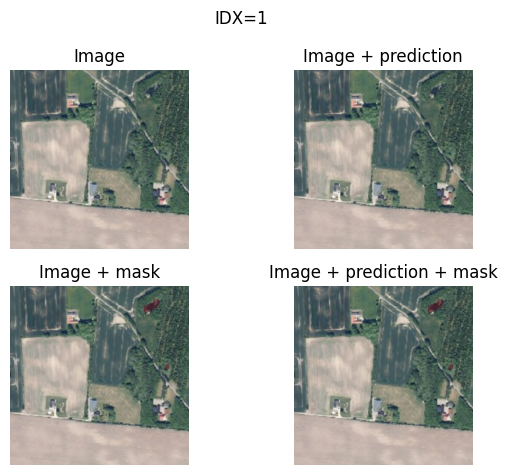

In [52]:
import matplotlib.pyplot as plt
import random
for idx in range(images.shape[0]):
    # idx = random.randint(0, images.shape[0]-1) # 5
    # print(f'idx = {idx}')
    
    # Example image: has shape (1, 3, 512, 512)
    # We squeeze the first dimension -> (3, 512, 512)
    # Then transpose so the RGB channels are last -> (512, 512, 3)
    # And make sure the colors are integers in the range 0...255
    example_image = np.squeeze(images[idx].cpu().numpy())
    example_image = np.round(example_image).astype(int)
    example_image = example_image.transpose(1,2,0)
    
    # Also squeeze dimensions of the predictions and mask
    # By using a masked version, we make the imshow transparent if there is no water
    example_pred = np.squeeze(preds[idx].cpu().numpy()).astype(int)
    example_pred = np.ma.masked_where(example_pred == 0, example_pred)
    
    
    example_mask = np.squeeze(masks[idx].cpu().numpy()).astype(int)
    example_mask = np.ma.masked_where(example_mask == 0, example_mask)
    
    fig, axs = plt.subplots(2, 2)
    for ax_row in axs:
        for ax in ax_row:
            ax.imshow(example_image)
            ax.axis('off')
    
    axs[0, 1].imshow(example_pred, alpha = 0.4, vmin = 0, vmax = 1, cmap = 'Blues')
    axs[1, 1].imshow(example_pred, alpha = 0.4, vmin = 0, vmax = 1, cmap = 'Blues')
    
    axs[1, 0].imshow(example_mask, alpha = 0.4, vmin = 0, vmax = 1, cmap = 'Reds')
    axs[1, 1].imshow(example_mask, alpha = 0.4, vmin = 0, vmax = 1, cmap = 'Reds')
    
    
    axs[0, 0].set_title("Image")
    axs[0, 1].set_title("Image + prediction")
    axs[1, 0].set_title("Image + mask")
    axs[1, 1].set_title("Image + prediction + mask")

    fig.suptitle(f'IDX={idx}')
    plt.tight_layout()
    plt.show()